# Generate Basic Report From Conversation

In [1]:
#System and my modules
import sys
sys.path.append("../tools/")

#Data managment
import pandas as pd 
import numpy as np

#Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#Utility 
import itertools as it
import copy
import datetime
import calendar

### MY TOOLS FOR MINING CONVERSATIONS ###
import MessFileReader as mfr

## Set Parameters and Get Data

In [2]:
#Set conv ID, it is name of folder in which message_1.json file is located
conv_id = '!ExampleConv'

In [3]:
#Create utility objects from conversation 
conv = mfr.readFile('../data/' + conv_id)
conv_params = mfr.getConvInfo(conv)
messages = mfr.getMessages(conv)

## Show basic information about conversation 

In [5]:
print('Title:   ', conv_params['title'])
print('Started: ', str(conv_params['first message'])[:-7])
print('Last:    ', str(conv_params['last message'])[:-7], '\n')
print('No. exchanged messages: ', len(messages))

Title:    Example Person
Started:  2011-10-20 20:56:36
Last:     2019-10-03 12:50:53 

No. exchanged messages:  116147


In [6]:
#Create Dictionary of Messages sent by given person
mess_dict = {}
for mess in messages: 
    try: 
        mess_dict[mess['sender_name']].append(mess)
    except KeyError:
        mess_dict[mess['sender_name']] = []
        mess_dict[mess['sender_name']].append(mess)

no_partic = len(mess_dict.keys())

## Find Messages by Date
For some reason messenger does not allow to search for messages by date. This functionality allows to do it.

In [16]:
#Get index of message that is closes to given date
inx = mfr.findByDate(messages, day=13, month=11, year=2011)
print(inx)

9


In [18]:
#Show messegs from given index range.
mfr.preetyPrintMess(messages, conv_params, inx, inx+3)


Example Person 2011-11-13 12:08:31
Hej


Bartłomiej Cerek 2011-11-13 12:09:57
hej lD


Example Person 2011-11-13 12:10:05
To cv z angielskiego musimy robić z tej strony cos tam europaszport ?? :)



## Show percentage of send messages
Show distribution of messages, what percent was send by a given person (especially interesting in group conversations) and create simple visualisation. 

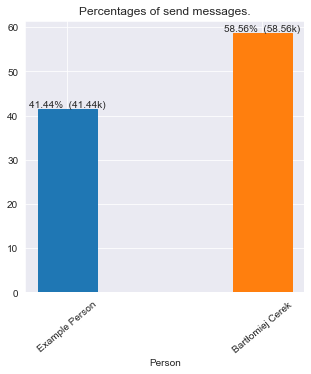

In [26]:
#Create Count Dict
counts={}
for name in mess_dict.keys():
    counts[name] = len(mess_dict[name])

#Crete series from dict for fast visualisation
counts_ser = pd.Series(counts).sort_values()
x = counts_ser.index.tolist()
y_no = counts_ser.to_numpy()
y = [el/sum(y_no)*100 for el in y_no]

#Set Figure Parameters
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
cont = ax.bar(x,y,width=0.3)

plt.xticks(rotation=40)
plt.title('Percentages of send messages.')
plt.xlabel('Person')

prop_iter = it.cycle(plt.rcParams['axes.prop_cycle'])
for rec in cont.patches:
    rec.set_color(next(prop_iter)['color'])

#Add annotations
for i, p in enumerate(cont.patches):
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{0:.2f}%  ({0:.2f}k)'.format(y.item(), y_no[i]/1000), (x.mean(), y), ha='center', va='bottom')

## Show percentage of send words
Show distribution of words, what percent was send by a given person and create simple visualisation. It can be interesting to compare with distribution of messages. 

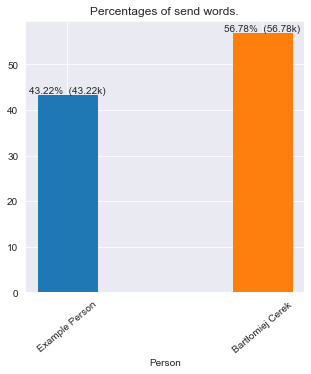

In [27]:
#Create Count Dict
word_counts={}
for name in mess_dict.keys():
    word_counts[name] = 0
    for mess in mess_dict[name]:  
        try: 
            word_counts[name] += len(mess['content'].split())
        except KeyError: 
            pass

#Crete series from dict for fast visualisation
word_counts_ser = pd.Series(word_counts).sort_values()
x = word_counts_ser.index.tolist()
y_no = word_counts_ser.to_numpy()
y = [el/sum(y_no)*100 for el in y_no]


#Set Figure Parameters
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
cont = ax.bar(x,y, width=0.3)

plt.xticks(rotation=40)

plt.title('Percentages of send words.')
plt.xlabel('Person')

prop_iter = it.cycle(plt.rcParams['axes.prop_cycle'])
for rec in cont.patches:
    rec.set_color(next(prop_iter)['color'])

for i, p in enumerate(cont.patches):
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{0:.2f}%  ({0:.2f}k)'.format(y.item(), y_no[i]/1000), (x.mean(), y), ha='center', va='bottom')

## Messages in time
See how amount of exchanged messages was changing in time. 
Messages are counted by months.

In [28]:
#Group messages by month
messages_timed = copy.deepcopy(messages)

#Change Timestamps to only use month and year
for mess in messages_timed:
    mess['timestamp_ms'] = mess['timestamp_ms'].date().replace(day=1)

#Count Messages by month
month_counts = {}
for mess in messages_timed:
    try:
        month_counts[mess['timestamp_ms']]+= 1
    except KeyError:
        month_counts[mess['timestamp_ms']] = 1

In [29]:
#Define function for month inceremt  // WAY TO COMPLEX
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

This cell execute quite long time becasuse it generates high resolution image that can be saved by uncommenting last line.

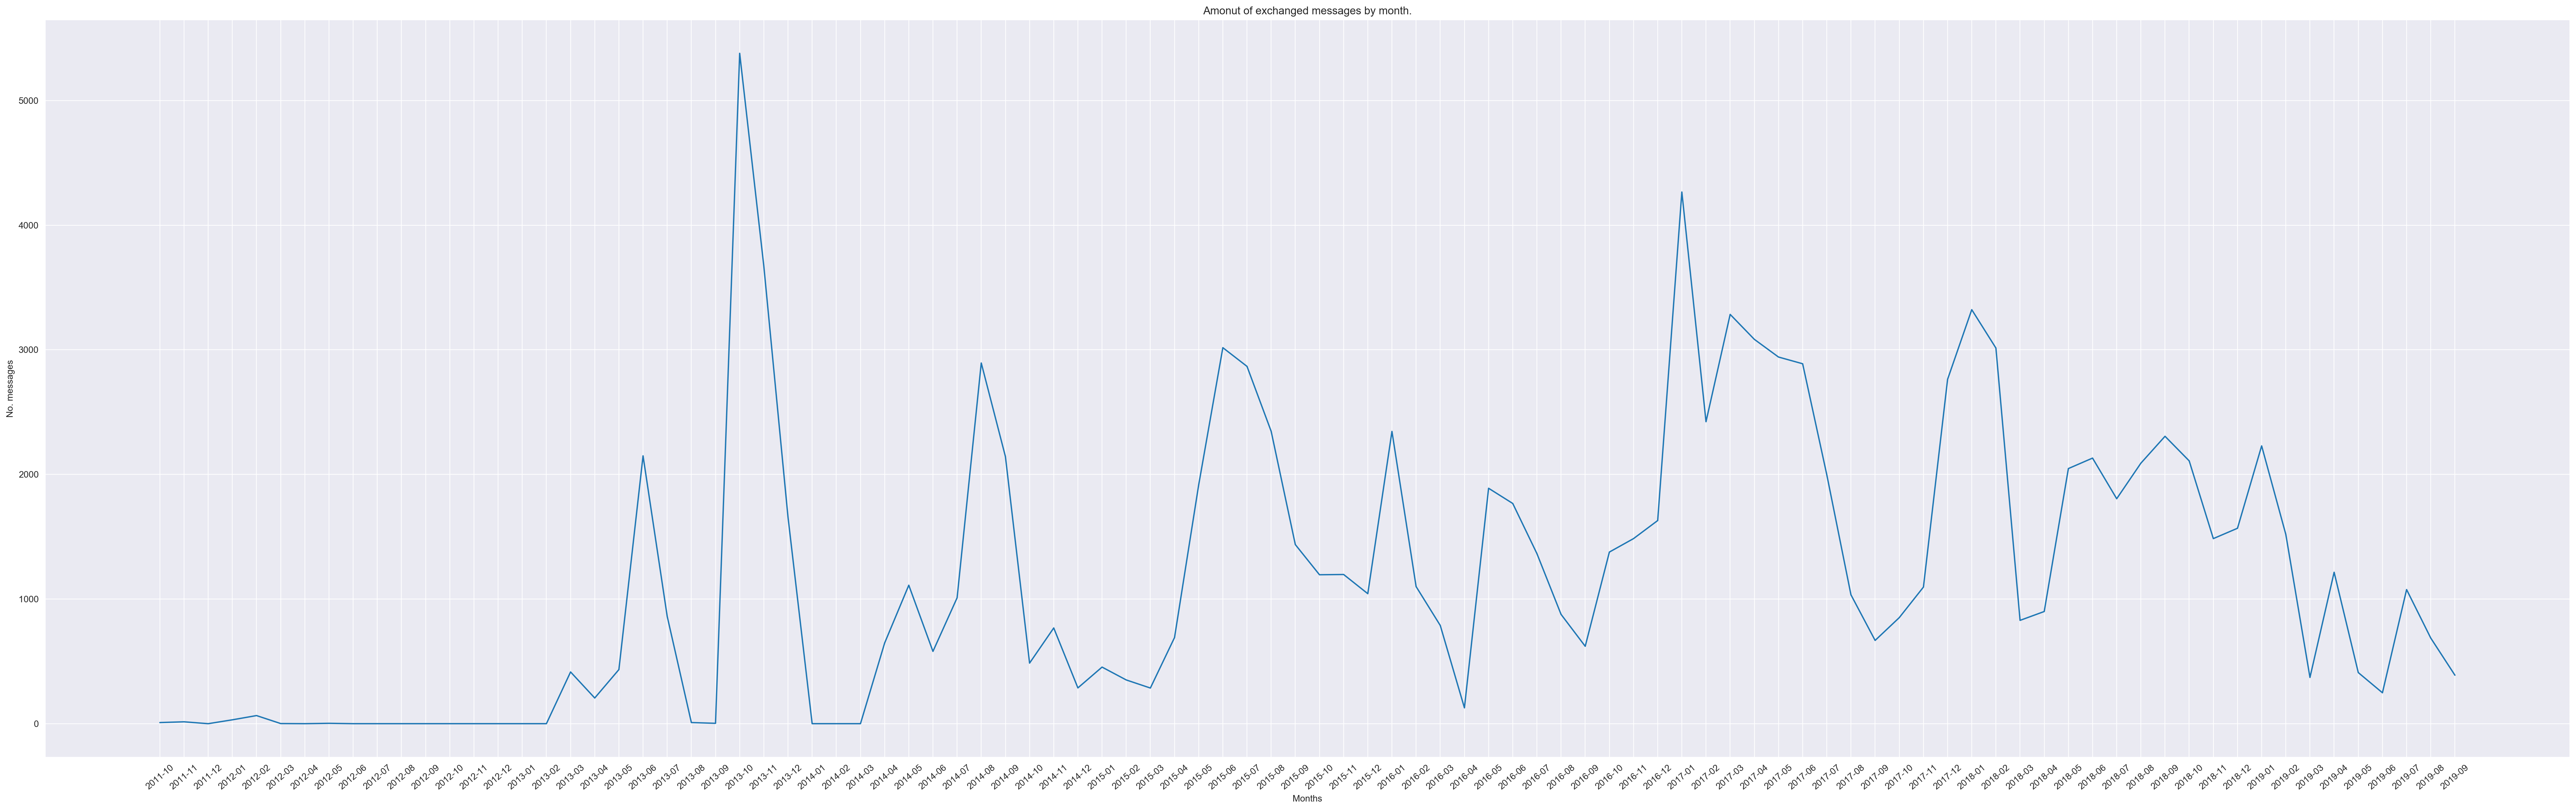

In [34]:
#Generate time series
start = sorted(month_counts.keys())[0]
end = sorted(month_counts.keys())[-1]

i = start#For iteration
timeseries = []
timeseries.append(i) #To include first el
while i<end:
    i = add_months(i,1)
    timeseries.append(i)
    
#Create series based on timeseries
month_counts_ser = pd.Series(index = timeseries)

#Fill series with data
for month in month_counts.keys():
    month_counts_ser[month] = month_counts[month] 

#Replace NaNs with 0
month_counts_ser = month_counts_ser.fillna(0)

#Filter out not full last month
if month_counts_ser.index[-1] == datetime.date(2019, 10, 1):
    month_counts_ser = month_counts_ser[0:-1]

x = month_counts_ser.index.tolist()
x = [str(i)[:-3] for i in x]
y = month_counts_ser.to_numpy()


fig = plt.figure(figsize=(50,15), dpi = 200)
plt.xticks(rotation=40)
plt.plot(x,y)

plt.title('Amonut of exchanged messages by month.')
plt.xlabel('Months')
plt.ylabel('No. messages');

#plt.savefig('conv.png')